# SATO Experiment
---

### Import and Functions

In [12]:
import sys
import os
import json
import argparse
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.interpolate import PchipInterpolator


load_dotenv()
sys.path.append(os.path.abspath("..")) 

from MM.model_selector import ModelSelector
from MM.agent.llm import LLMAgent


In [13]:
def load_data(test_path):
    assert test_path.endswith(".jsonl"), f"Invalid test_path, must be a valid jsonl file: {test_path}"
    with open(test_path, "r") as f:
        task_configs = [json.loads(line) for line in f]
    
    return task_configs

In [14]:
def selector_config()->argparse.Namespace:
    parser = argparse.ArgumentParser(
        description=f"Initiate config for Model Selector"
    )

    #General
    parser.add_argument("--n_cluster", type=int, default=5)
    parser.add_argument("--sample_rate", type=float, default=0.001)

    #Thompson
    parser.add_argument("--prior_size", type=int, default=16)

    #Succesive Reject
    parser.add_argument("--eval_size", type=int, default=16)
    parser.add_argument("--strategy", default="vanilla", help="['vanilla', 'halving']")
    

    #UCB
    parser.add_argument("--eval_rate", type=float, default=0.2)
    parser.add_argument("--k_model", type=int, default=3)
    parser.add_argument("--coeff", type=float, default=0.5)
    parser.add_argument("--rounds", type=int, default=10)

    args = parser.parse_known_args()
    return args

In [15]:
def model_config(model:str, cost: float) -> argparse.Namespace:
    parser = argparse.ArgumentParser(
        description=f"Initiate config for {model}"
    )
    
    #Path settings
    parser.add_argument("--system_prompt_path", help="System prompt file path", default="/home/yosef/ace/mm/MM/agent/prompts/sato_prompt.txt")
    parser.add_argument("--domain_path", help="Domain directory path", default="/home/yosef/ace/mm/MM/dataset/sato/domains.pkl")
    parser.add_argument("--condition_path", help="Evaluation condition path", default="/home/yosef/ace/mm/MM/dataset/sato/sato.jsonl")

    #LLM settings
    parser.add_argument("--model", type=str, default = model)
    parser.add_argument("--cost", type=float, default = cost)
    parser.add_argument("--temperature", type=float, default=0.0)
    parser.add_argument("--top_p", type=float, default=1.0)
    parser.add_argument("--max_new_tokens", type=int, default=4000)
    parser.add_argument("--stop_token", type=str, default=None)
    parser.add_argument("--prompt_strategy", default="cta-agent", 
                       choices=["cta-agent"],
                       help="Prompt building strategy")
    parser.add_argument("--task", type=str, default = "cta")

    # Execution settings
    parser.add_argument("--api_host", default="localhost", help="API host")
    parser.add_argument("--api_port", default="5000", help="API port")
    parser.add_argument("--max_rounds", type=int, default=1, help="Max conversation rounds")


    args = parser.parse_known_args()
    return args

In [16]:

def plot_pf_sorted(data, filename=None):
    df = pd.DataFrame(data)
    df_sorted = df.sort_values("Cost", ascending=True).reset_index(drop=True)

    frontier_idx = []
    max_score_so_far = -np.inf
    for idx, row in df_sorted.iterrows():
        if row["Score"] > max_score_so_far:
            frontier_idx.append(idx)
            max_score_so_far = row["Score"]
    pf = df_sorted.loc[frontier_idx]

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.set(style="whitegrid", font_scale=1.2)

    if len(pf) >= 2:
        log_c = np.log(pf["Cost"].values)
        scores = pf["Score"].values
        spline = PchipInterpolator(log_c, scores)

        log_xs = np.linspace(log_c.min(), log_c.max(), 300)
        xs = np.exp(log_xs)
        ys = spline(log_xs)

        ax.plot(
            xs, ys,
            color="red", linewidth=1.5, zorder=1, alpha=0.6,
            label="_nolegend_"
        )
    elif len(pf) == 2:
        ax.plot(
            pf["Cost"], pf["Score"],
            color="red", linewidth=1.5, zorder=1, alpha=0.6,
            label="_nolegend_"
        )

    sns.scatterplot(
        x="Cost", y="Score",
        hue="Model",
        palette="tab20",
        data=df_sorted,
        s=120,
        edgecolor="white",
        linewidth=1.2,
        ax=ax,
        legend="full",
        zorder=2
    )

    ax.set_xscale("log")
    cost_ticks = df_sorted["Cost"].unique()
    ax.set_xticks(cost_ticks)
    ax.set_xticklabels([f"{c:g}" for c in cost_ticks])

    ax.set_xlim(0.1, 50)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Cost Input and Output ($/1 M Tokens)", fontsize=13)
    ax.set_ylabel("Arena Score", fontsize=13)

    ax.legend(
        title="Model",
        loc="best",
        frameon=True,
        framealpha=0.8
    )

    ax.grid(True, which="both", linestyle="--", linewidth=0.3, alpha=0.25)
    plt.tight_layout()

    if filename:
        fig.savefig(filename, bbox_inches="tight", dpi=300)

    plt.show()
    return fig, ax


### Main

In [17]:
import subprocess

subprocess.Popen(
    ["bash", "/home/yosef/ace/mm/experiments/run_server.sh"],
    stdout=None,
    stderr=subprocess.STDOUT
)


<Popen: returncode: None args: ['bash', '/home/yosef/ace/mm/experiments/run_...>

In [18]:
plafortm_conf = selector_config()
configs = [model_config("google/gemini-2.0-flash-001",0.225), model_config("google/gemini-2.5-flash",0.45), model_config("google/gemini-2.5-pro",2.5)]

dataset = load_data(os.path.join(os.path.abspath(".."),"MM/dataset/sato/sato.jsonl"))
models = list()
for conf in configs:
    models.append(LLMAgent(conf[0]))

selector = ModelSelector( models=models, args=plafortm_conf[0])


/home/yosef/miniconda3/envs/mm/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Cluster Sampling

In [25]:
cs_res = selector.cluster_sampling(dataset)
print(cs_res)

[14:18:03] Start Sampling
[14:18:32] Start Evaluating LLMAgent(name=google/gemini-2.0-flash-001)
[14:18:37] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2693 | Scored :False
[14:18:39] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2744 | Scored :False
[14:18:40] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2747 | Scored :False
[14:18:41] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2844 | Scored :True
[14:18:46] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2960 | Scored :True
[14:18:47] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2991 | Scored :True
[14:18:48] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 3209 | Scored :True
[14:18:49] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 4083 | Scored :False
[14:18:50] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 6464 | Scored :False
[14:18:51] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 13878 | Scored :True
[14:18:53] LLMAgent(name=google/gemin

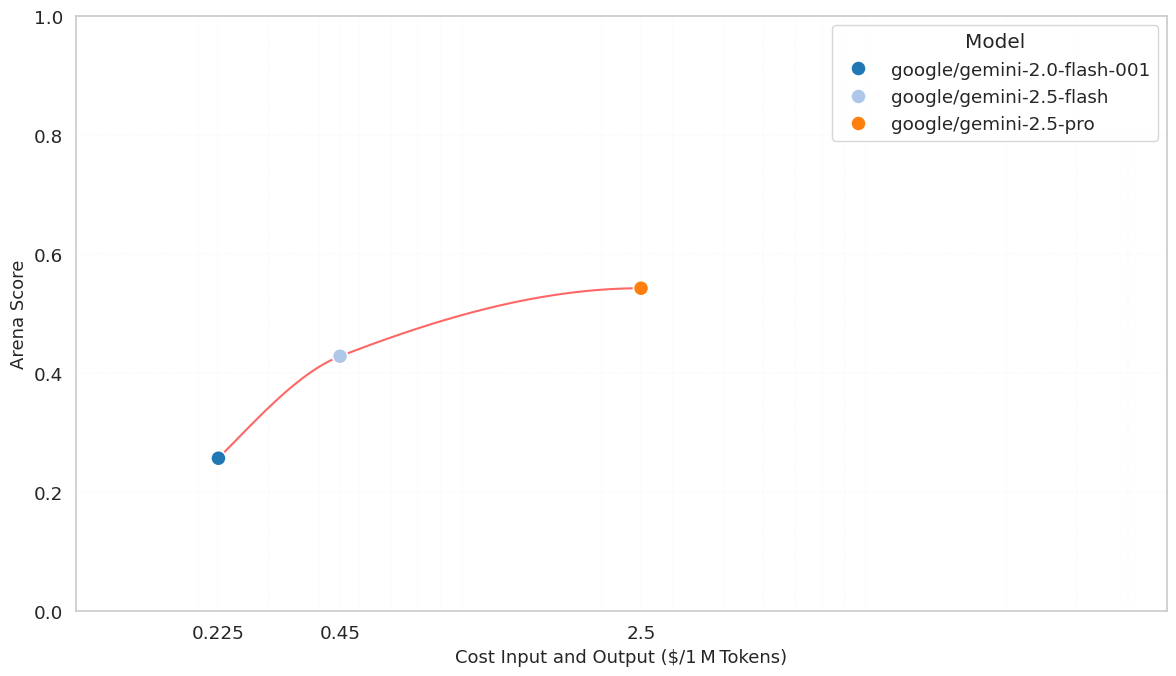

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [26]:
cs_shw = []
for idx,conf in enumerate(configs):
    cs_shw.append({
        "Model":conf[0].model,
        "Cost": conf[0].cost,
        "Score":cs_res[idx]
    })

plot_pf_sorted(cs_shw,"cs_sato.png")

### Cluster Sampling + Thompson Sampling

In [23]:
csts_res = selector.cluster_sampling_thompson(dataset)
print(csts_res)

[08:32:26] Start Sampling
[08:33:00] Start Computing prior LLMAgent(name=google/gemini-2.0-flash-001)
[08:33:03] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 3017 | Scored :True
[08:33:04] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 16925 | Scored :True
[08:33:05] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 25269 | Scored :False
[08:33:06] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 3437 | Scored :False
[08:33:07] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 13524 | Scored :True
[08:33:08] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 16117 | Scored :False
[08:33:09] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 14573 | Scored :True
[08:33:10] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 3408 | Scored :True
[08:33:12] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 5910 | Scored :False
[08:33:13] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 22418 | Scored :False
[08:33:14] LLMAgent(name=go

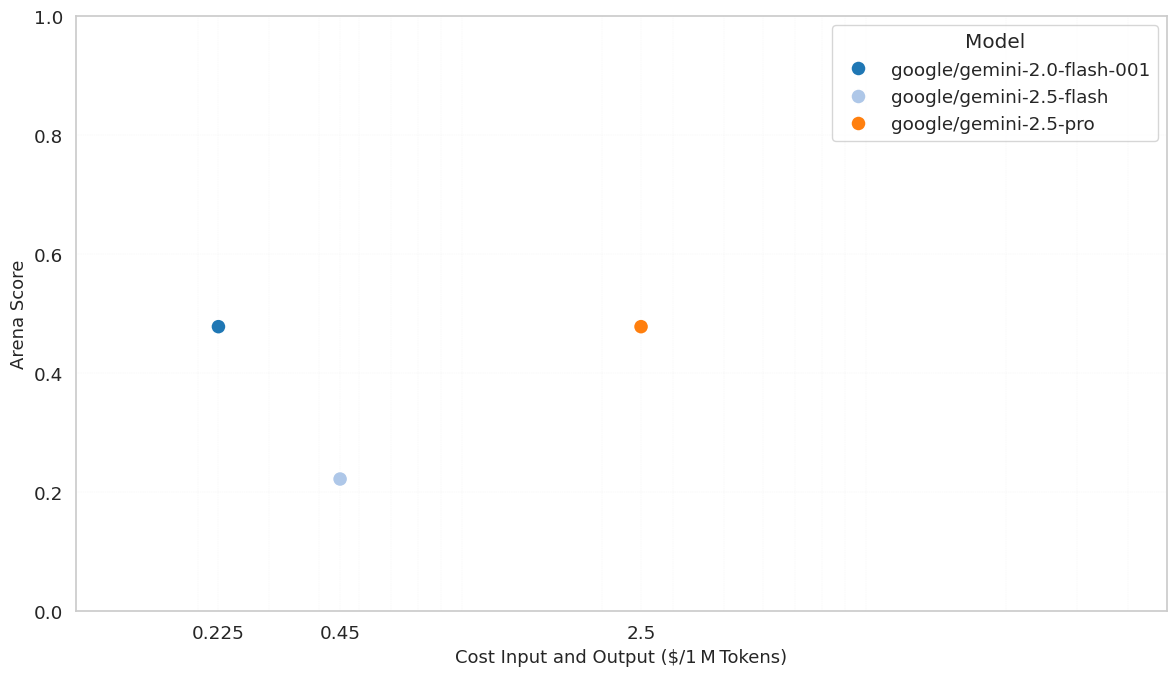

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [24]:
csts_shw = []
for idx,conf in enumerate(configs):
    csts_shw.append({
        "Model":conf[0].model,
        "Cost": conf[0].cost,
        "Score":csts_res[idx]
    })

plot_pf_sorted(csts_shw,"csts_sato.png")


### Succesive Reject

In [21]:
sr_res = selector.succesive_reject(dataset)
print(sr_res)

[08:24:11] Start Sampling
[08:24:49] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2643 | Scored :False
[08:24:50] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2721 | Scored :False
[08:24:51] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2754 | Scored :False
[08:24:52] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2856 | Scored :False
[08:24:53] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2933 | Scored :True
[08:24:54] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 3008 | Scored :False
[08:24:55] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 3209 | Scored :True
[08:24:56] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 4097 | Scored :False
[08:24:58] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 6518 | Scored :False
[08:24:58] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 13880 | Scored :False
[08:25:00] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 14031 | Scored :True
[08:25:00] LLMAgen

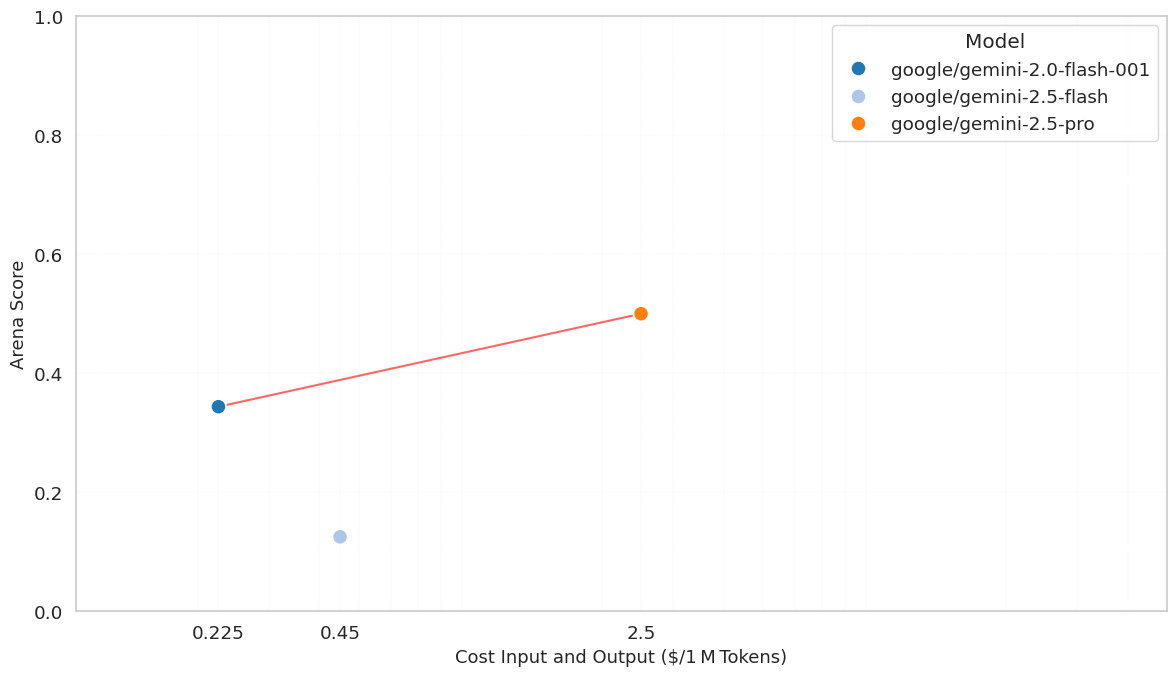

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [22]:
df = pd.DataFrame(sr_res)
df_filled = df.fillna(0)
col_avg = df_filled.mean().tolist()

sr_shw = []
for idx,conf in enumerate(configs):
    sr_shw.append({
        "Model":conf[0].model,
        "Cost": conf[0].cost,
        "Score":col_avg[idx]
    })
plot_pf_sorted(sr_shw,"sr_sato.png")


### UCB

In [19]:
ucb_res = selector.ucb(dataset)
print(ucb_res)

[08:17:00] Start Sampling
[08:17:39] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 31440 | Scored :False
[08:17:40] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2802 | Not Terminated!
[08:17:41] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 22457 | Scored :True
[08:17:43] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 25362 | Scored :False
[08:17:44] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 14070 | Scored :True
[08:17:45] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 13863 | Scored :True
[08:17:46] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 2984 | Scored :True
[08:17:53] LLMAgent(name=google/gemini-2.5-flash) | Instance: 21692 | Scored :False
[08:18:04] LLMAgent(name=google/gemini-2.5-flash) | Instance: 27648 | Scored :False
[08:18:09] LLMAgent(name=google/gemini-2.5-flash) | Instance: 6464 | Scored :False
[08:18:13] LLMAgent(name=google/gemini-2.5-flash) | Instance: 2868 | Scored :False
[08:18:14] LLMAgent(name=goo

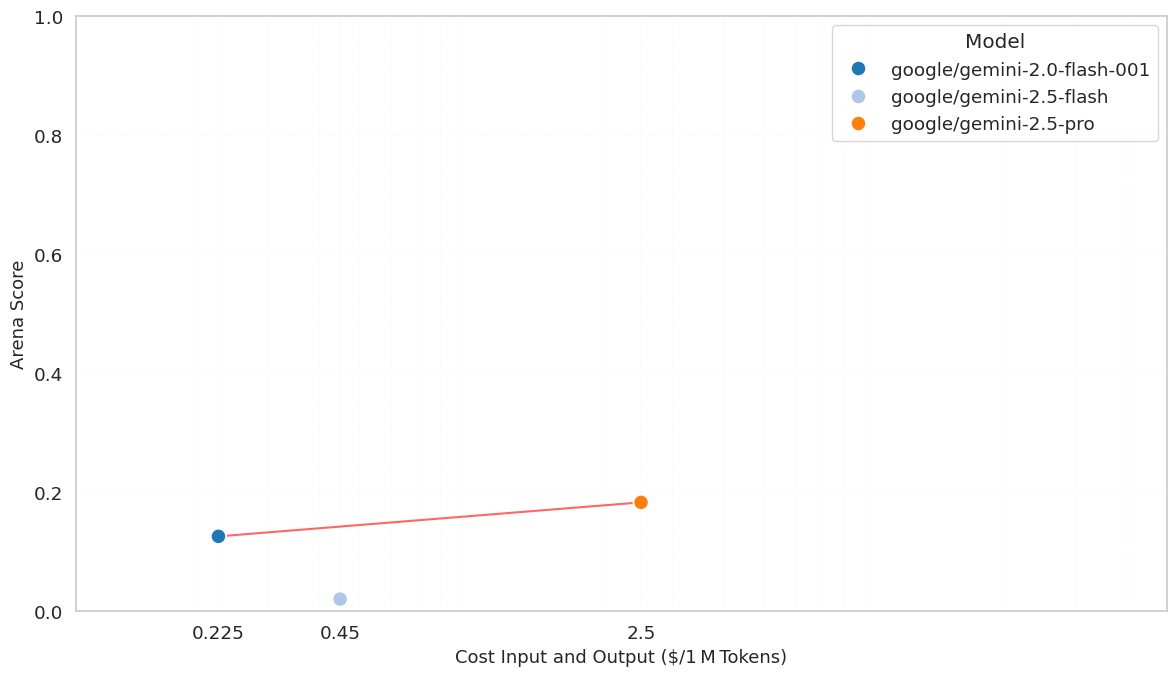

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [20]:
ucb_shw = []
for res in ucb_res:
    ucb_shw.append({
        "Model":configs[res[0]][0].model,
        "Cost": configs[res[0]][0].cost,
        "Score":res[2]
    })
plot_pf_sorted(ucb_shw,"ucb_sato.png")
